In [1]:
import os
import csv

# Directory containing the files
directory = "namesbystate"

# Dictionary to store the data
data = {}

# List all files in the directory
files = os.listdir(directory)

# Filter out files that match the pattern "STATE.*.txt"
state_files = [f for f in files if f.startswith("STATE")]

# Read each state file
for state_file in state_files:
    state_abbr = state_file.split('.')[1]  # Extract state abbreviation from the filename
    
    # Initialize the state dictionary if not already present
    if state_abbr not in data:
        data[state_abbr] = {}
    
    with open(os.path.join(directory, state_file), 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            year = int(row[2])
            name_gender_key = f"{row[3]}_{row[1]}"
            
            # Initialize the year dictionary if not already present
            if year not in data[state_abbr]:
                data[state_abbr][year] = {}
            
            data[state_abbr][year][name_gender_key] = int(row[4])
# print(data["AZ"][1910]["Mary_F"])


In [14]:
from gensim import corpora, models
from gensim.models import TfidfModel

tokenized_documents = []  # List to store tokenized documents
documents = []  # List to store bag-of-words representations
for state, years in data.items():
    for y in range(2020, 2021, 5):
        if y in years:
            names = []
            for name, count in years[y].items():
                names.extend([name] * count)
            tokenized_documents.append(names)

# Continue with your existing dictionary and corpus creation
dictionary = corpora.Dictionary(tokenized_documents)
corpus = [dictionary.doc2bow(document) for document in tokenized_documents]

In [18]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import KFold

# Define a list of hyperparameter values to search
num_topics_list = list(range(2, 15))
kfolds = 5  # Number of folds for cross-validation

best_lda_model = None
best_coherence_score = -1

# Perform k-fold cross-validation
kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)

for num_topics in num_topics_list:
    fold_coherence_scores = []

    for train_idx, val_idx in kf.split(corpus):
        train_corpus_fold = [corpus[i] for i in train_idx]
        val_corpus_fold = [corpus[i] for i in val_idx]

        lda = LdaModel(corpus=train_corpus_fold, id2word=dictionary, num_topics=num_topics)

        val_texts = [tokenized_documents[i] for i in val_idx]  # Extract tokenized texts for validation
        coherence_model = CoherenceModel(model=lda, texts=val_texts, dictionary=dictionary, coherence='c_v')
        fold_coherence_scores.append(coherence_model.get_coherence())
        #print(coherence_model.get_coherence())



    # Average coherence scores across folds
    avg_coherence_score = sum(fold_coherence_scores) / len(fold_coherence_scores)
    print(avg_coherence_score)
    # Check if this model has the highest average coherence score so far
    if avg_coherence_score > best_coherence_score:
        best_coherence_score = avg_coherence_score
        best_lda_model = lda

# The best_lda_model will have the best hyperparameter settings based on cross-validation


0.6944269617754029
0.6926859447772672
0.6902436131365649
0.6925846674755227
0.698173992855446
0.6931080469031649
0.6905418363218109
0.6927030947254458
0.6944250787225192
0.6934983588432541
0.6933126302919987
0.6977063613475628
0.6948103588678822


In [19]:
print(best_lda_model)

LdaModel(num_terms=9344, num_topics=6, decay=0.5, chunksize=2000)


In [20]:
lda = best_lda_model
print(lda.num_topics)

6


In [21]:
from gensim import models
import numpy as np

# Assuming lda is your trained LdaModel and dictionary is your Gensim dictionary

num_topics = lda.num_topics  # Number of topics in the model
topic_word_distributions = {topic: dict(lda.show_topic(topic, topn=len(dictionary))) for topic in range(num_topics)}

# Function to find distinctive words for each topic
def find_distinctive_words(topic_word_distributions):
    distinctive_words = {}
    for topic in topic_word_distributions:
        other_topics = set(topic_word_distributions.keys()) - {topic}
        word_scores = {}

        for word, prob in topic_word_distributions[topic].items():
            max_prob_other_topics = np.mean([topic_word_distributions[ot].get(word, 0) for ot in other_topics])
            distinctiveness_score = prob - max_prob_other_topics
            word_scores[word] = distinctiveness_score

        # Sort words by distinctiveness score
        distinctive_words[topic] = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

    return distinctive_words

# Get distinctive words for each topic
distinctive_words_per_topic = find_distinctive_words(topic_word_distributions)

# Print distinctive words for each topic
for topic, words in distinctive_words_per_topic.items():
    print(f"Topic {topic}:")
    for word, score in words[:20]:  # Adjust the number to get more or fewer words
        print(f"  {word}: {score}")
    print("\n")


Topic 0:
  Olivia_F: 0.0015466082841157913
  Christopher_M: 0.0009399470873177052
  Ella_F: 0.0008875373750925064
  Logan_M: 0.0008481992408633232
  Emma_F: 0.0007656179368495941
  Levi_M: 0.000757092610001564
  Wyatt_M: 0.0006923223845660686
  Aiden_M: 0.0006809781771153212
  Jackson_M: 0.0006794845685362816
  Carson_M: 0.0006374572403728962
  Harper_F: 0.0006244231481105089
  Sadie_F: 0.0006105118663981557
  Serenity_F: 0.000603749300353229
  Scarlett_F: 0.0005949945189058781
  Paisley_F: 0.0005634264089167118
  Christian_M: 0.0005534319207072258
  Abigail_F: 0.0005446029826998711
  Daniel_M: 0.0005118809640407562
  Genesis_F: 0.0005081568378955126
  Gianna_F: 0.000505243893712759


Topic 1:
  Oliver_M: 0.001927720382809639
  Noah_M: 0.0017905114218592644
  William_M: 0.0015976103022694588
  Joseph_M: 0.0014749930705875158
  Jackson_M: 0.001282039564102888
  Ava_F: 0.0010741022415459156
  Nora_F: 0.001063555828295648
  Joshua_M: 0.0009287139400839806
  Emma_F: 0.00090742576867342
  I

In [22]:
states = list(data.keys())

state_topic_distributions = {}

for state, bow in zip(states, corpus):
    state_topic_distributions[state] = lda.get_document_topics(bow, minimum_probability=0)

# Print the topic distribution for each state
for state, distribution in state_topic_distributions.items():
    print(f"State: {state}, Distribution: {distribution}")


State: ID, Distribution: [(0, 0.046936408), (1, 0.16039689), (2, 0.12385129), (3, 0.24466208), (4, 0.30398676), (5, 0.120166585)]
State: DC, Distribution: [(0, 0.07398056), (1, 0.19195728), (2, 0.12094674), (3, 0.084805794), (4, 0.3408787), (5, 0.18743089)]
State: KY, Distribution: [(0, 0.123023756), (1, 0.16382025), (2, 0.12301884), (3, 0.17170079), (4, 0.30274773), (5, 0.11568864)]
State: DE, Distribution: [(0, 0.14135809), (1, 0.10880551), (2, 0.15002136), (3, 0.1022055), (4, 0.3867385), (5, 0.11087104)]
State: FL, Distribution: [(0, 0.17599453), (1, 0.11327597), (2, 0.15465733), (3, 0.1114013), (4, 0.28310132), (5, 0.16156952)]
State: PA, Distribution: [(0, 0.1194917), (1, 0.16746019), (2, 0.11255607), (3, 0.1529018), (4, 0.25365722), (5, 0.19393303)]
State: RI, Distribution: [(0, 0.08104841), (1, 0.14296275), (2, 0.1462492), (3, 0.13376541), (4, 0.31694573), (5, 0.17902847)]
State: IA, Distribution: [(0, 0.053539194), (1, 0.19639674), (2, 0.14610952), (3, 0.19680835), (4, 0.294321

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


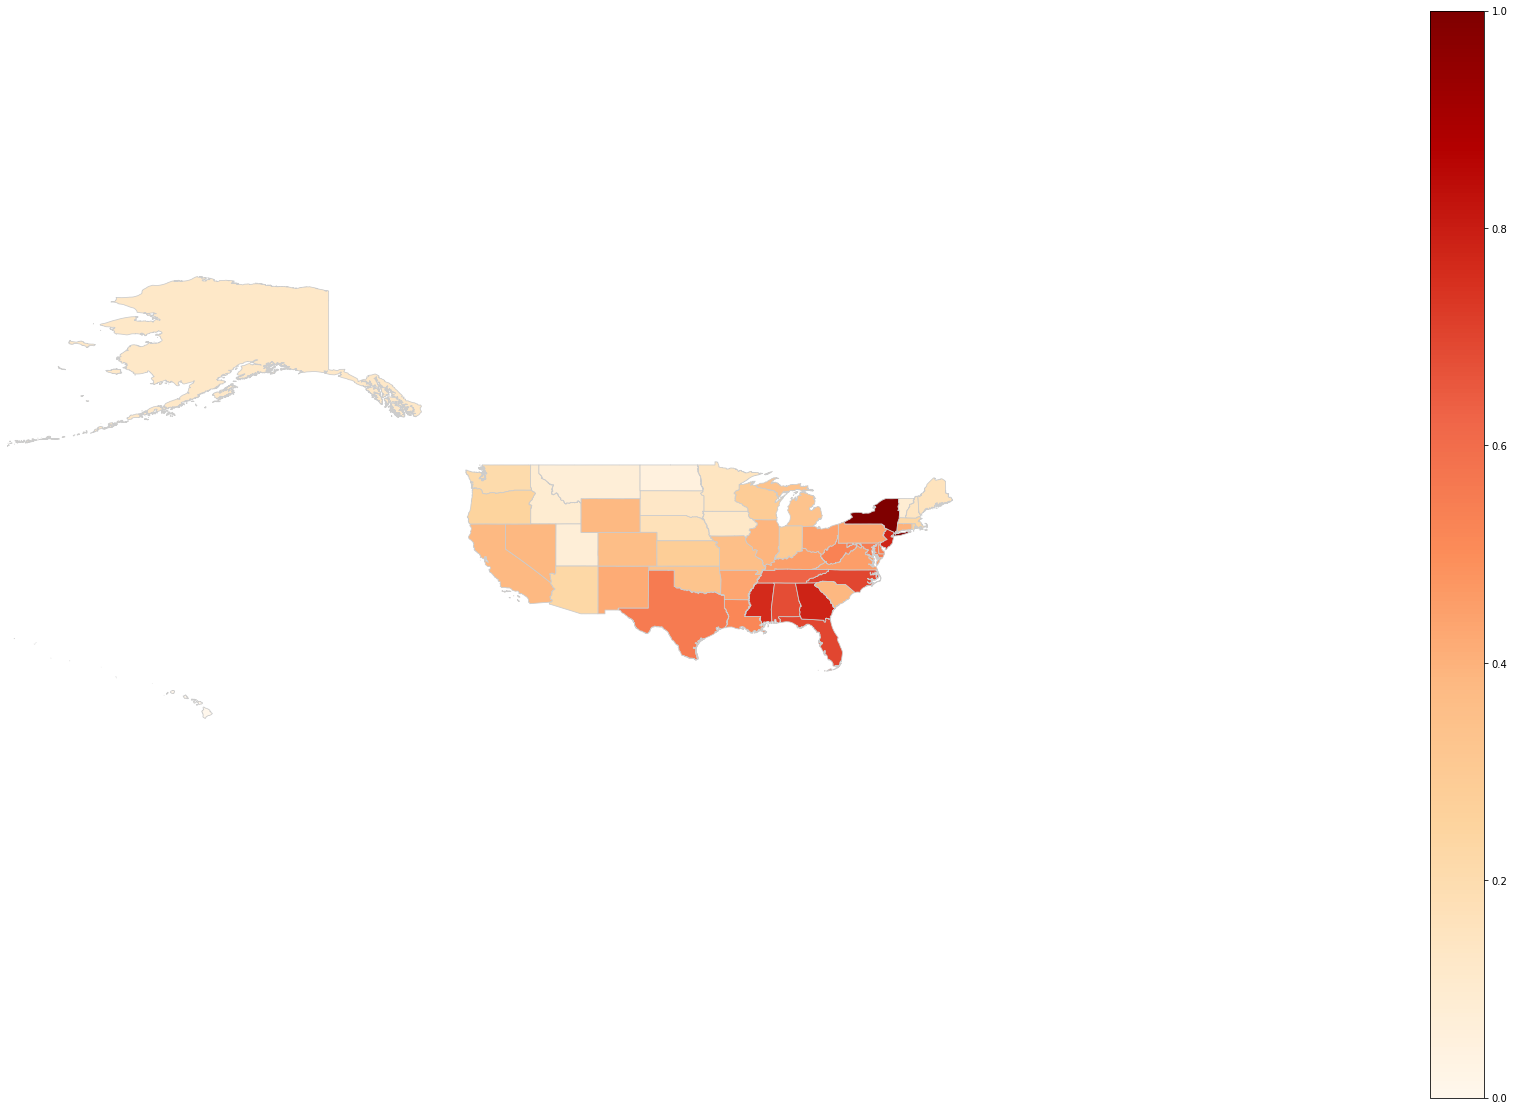

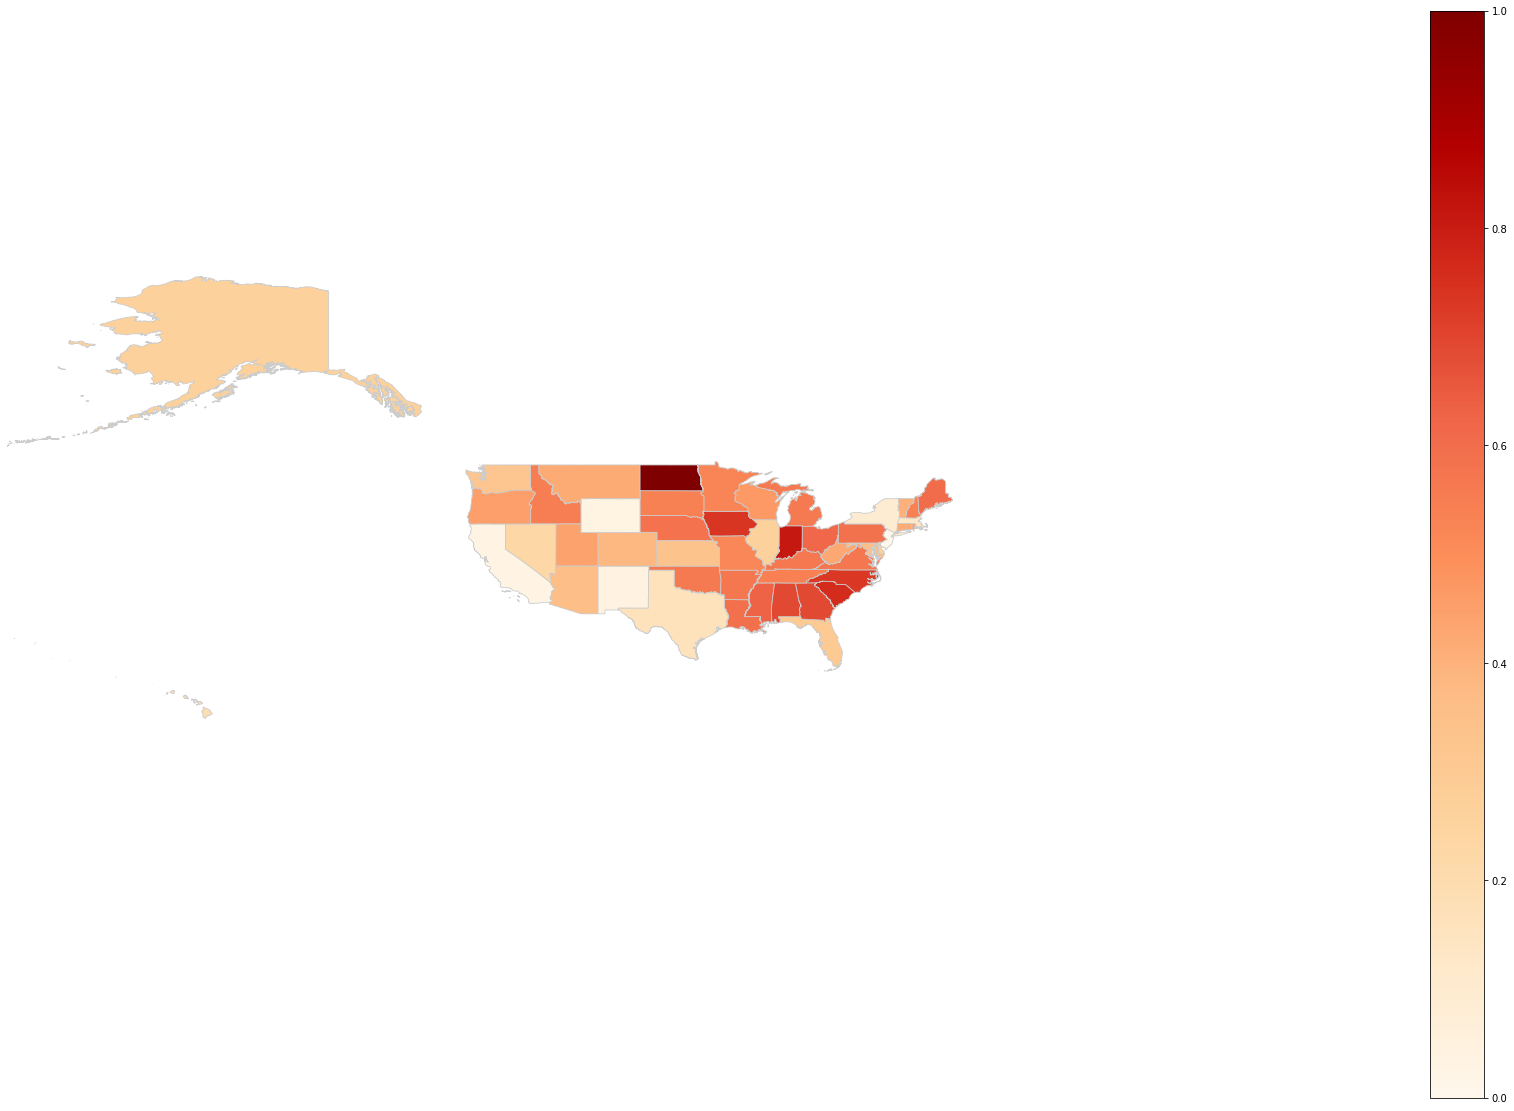

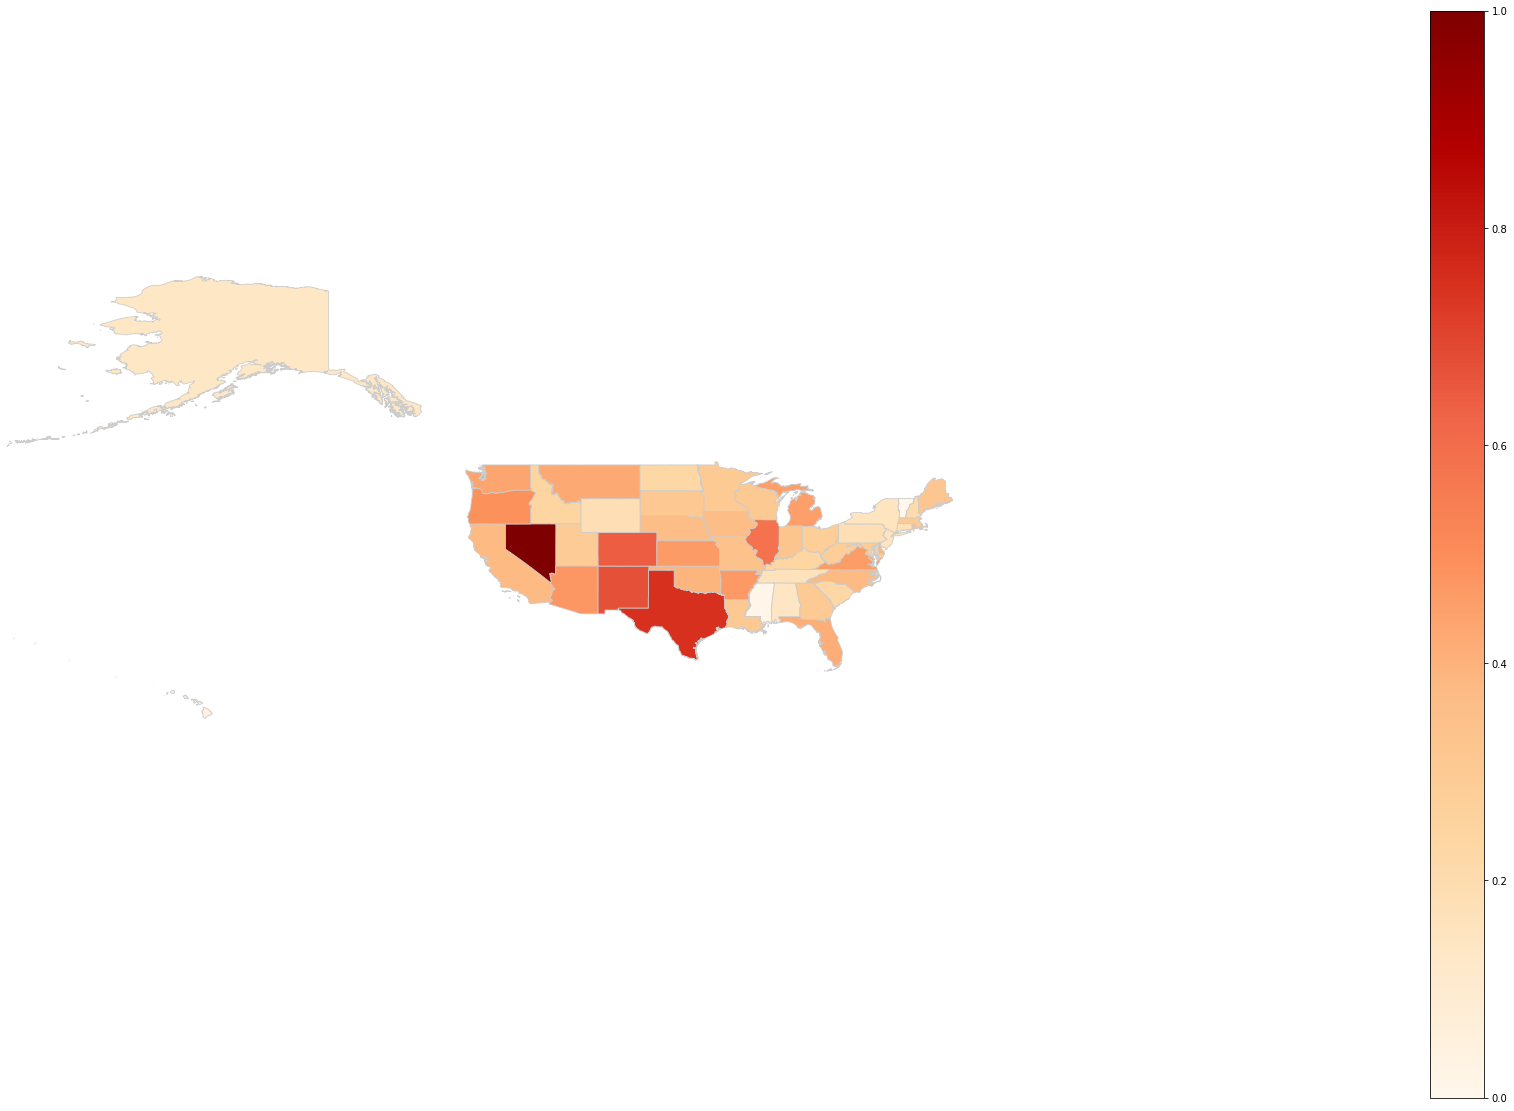

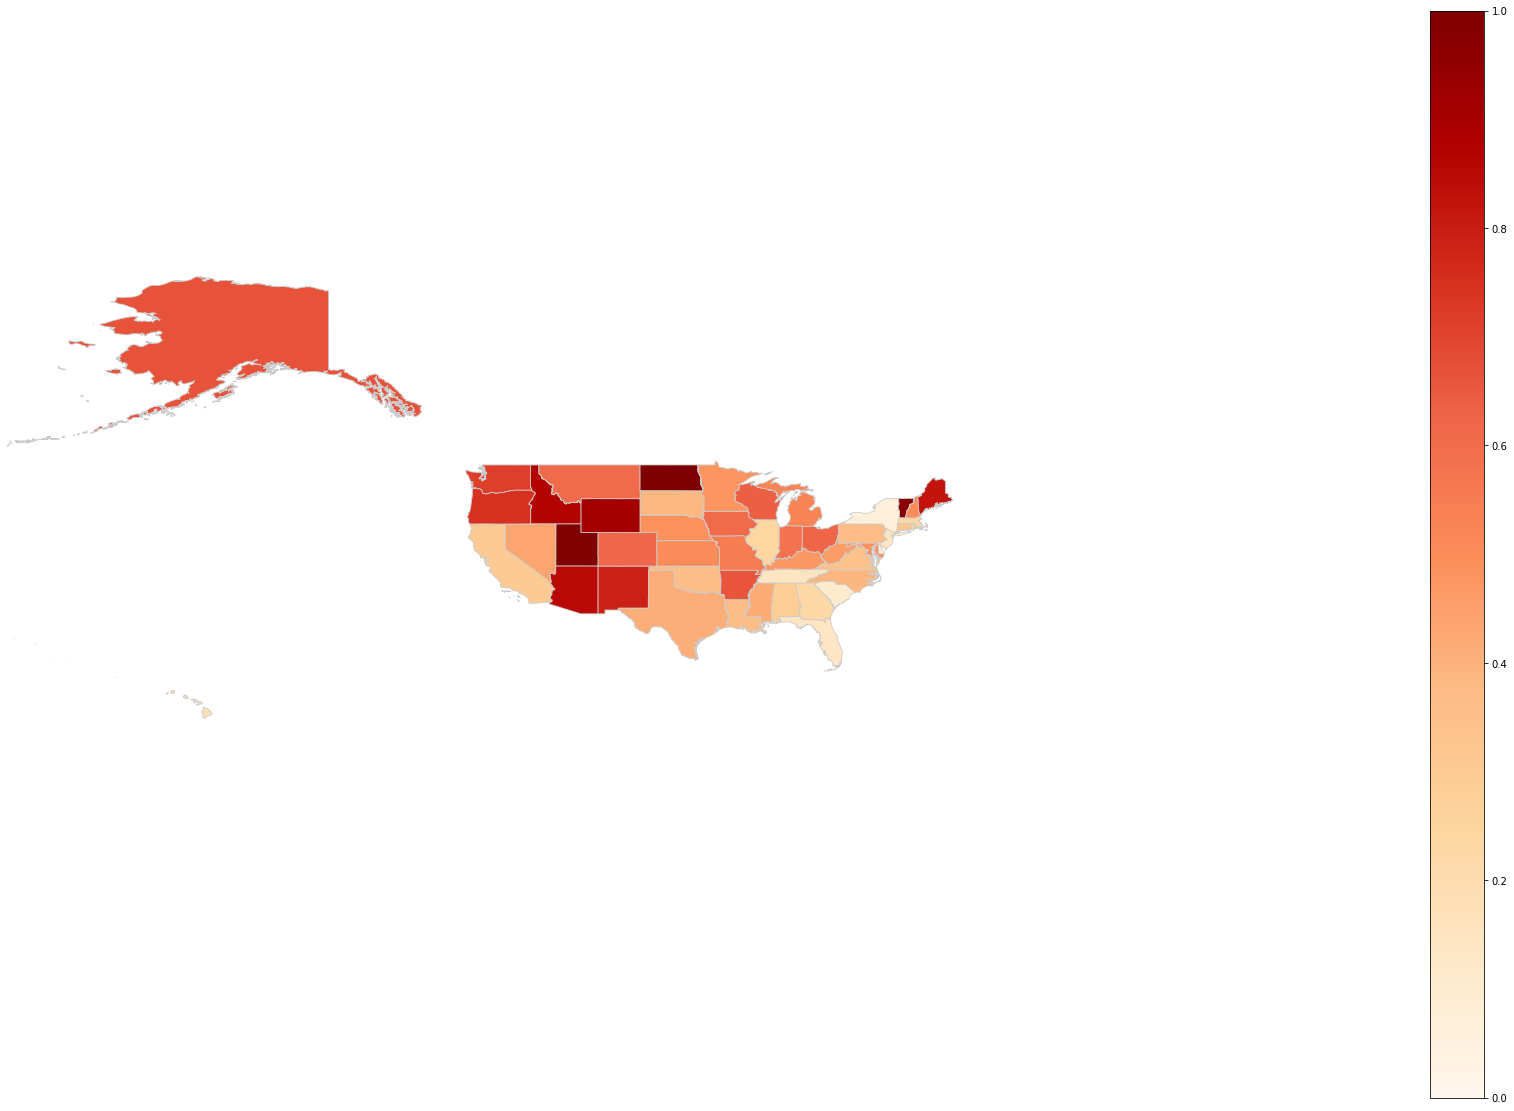

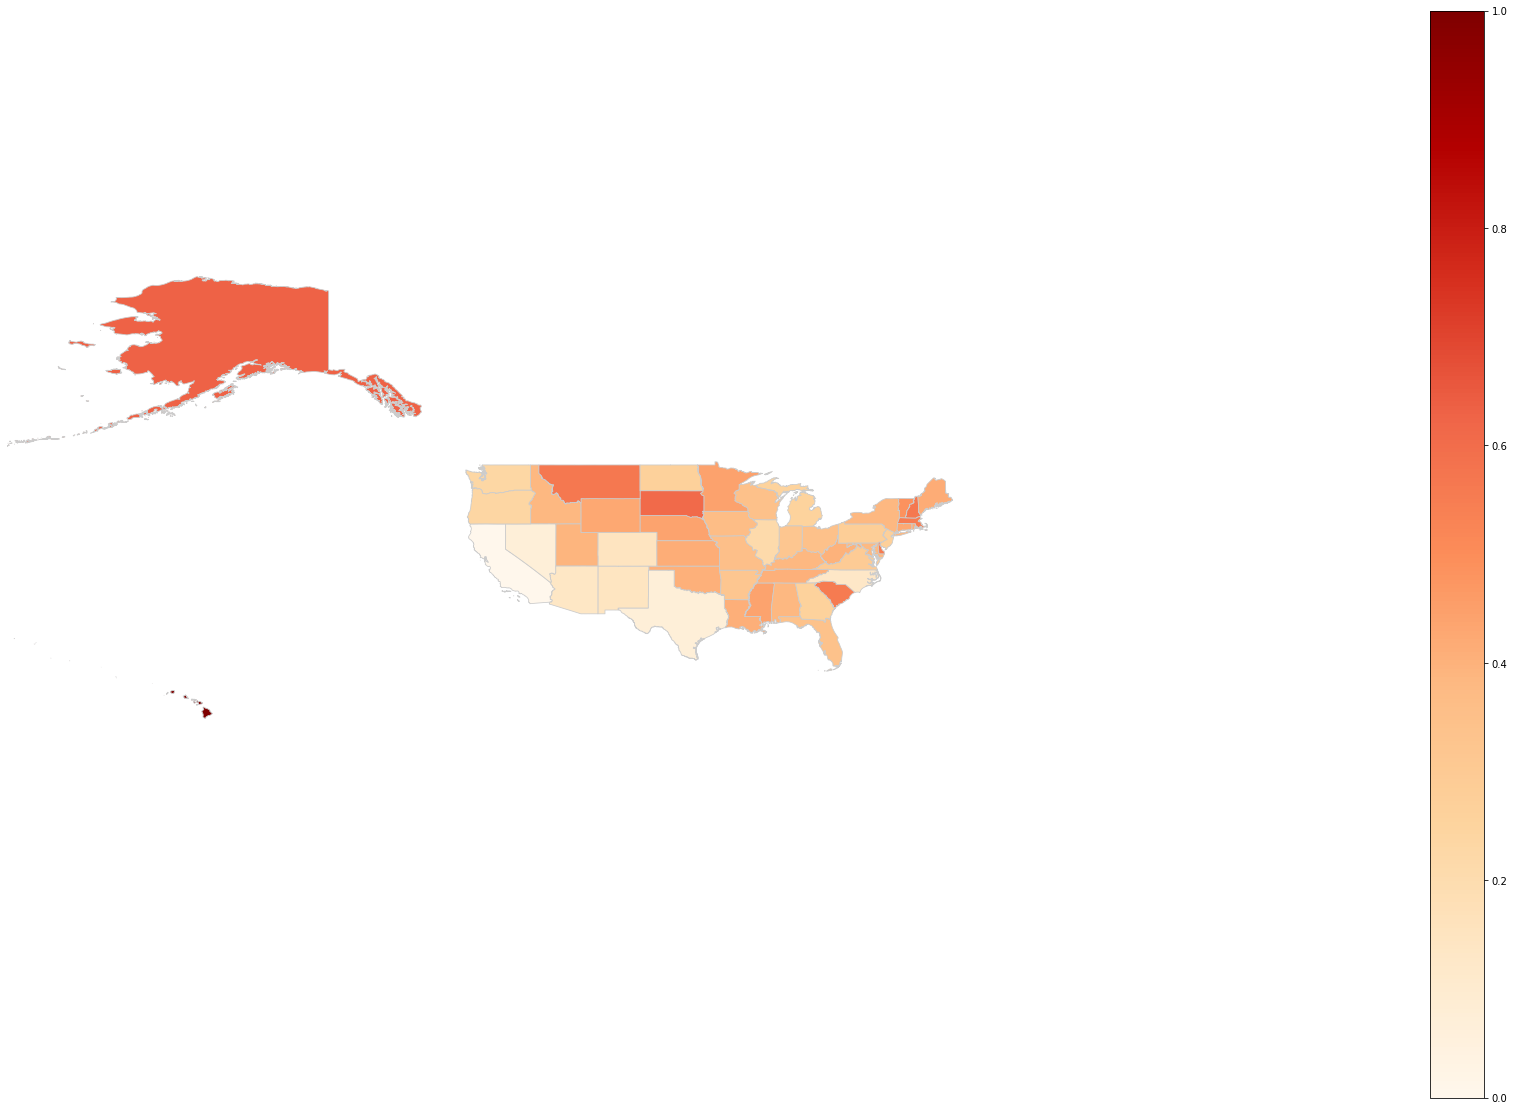

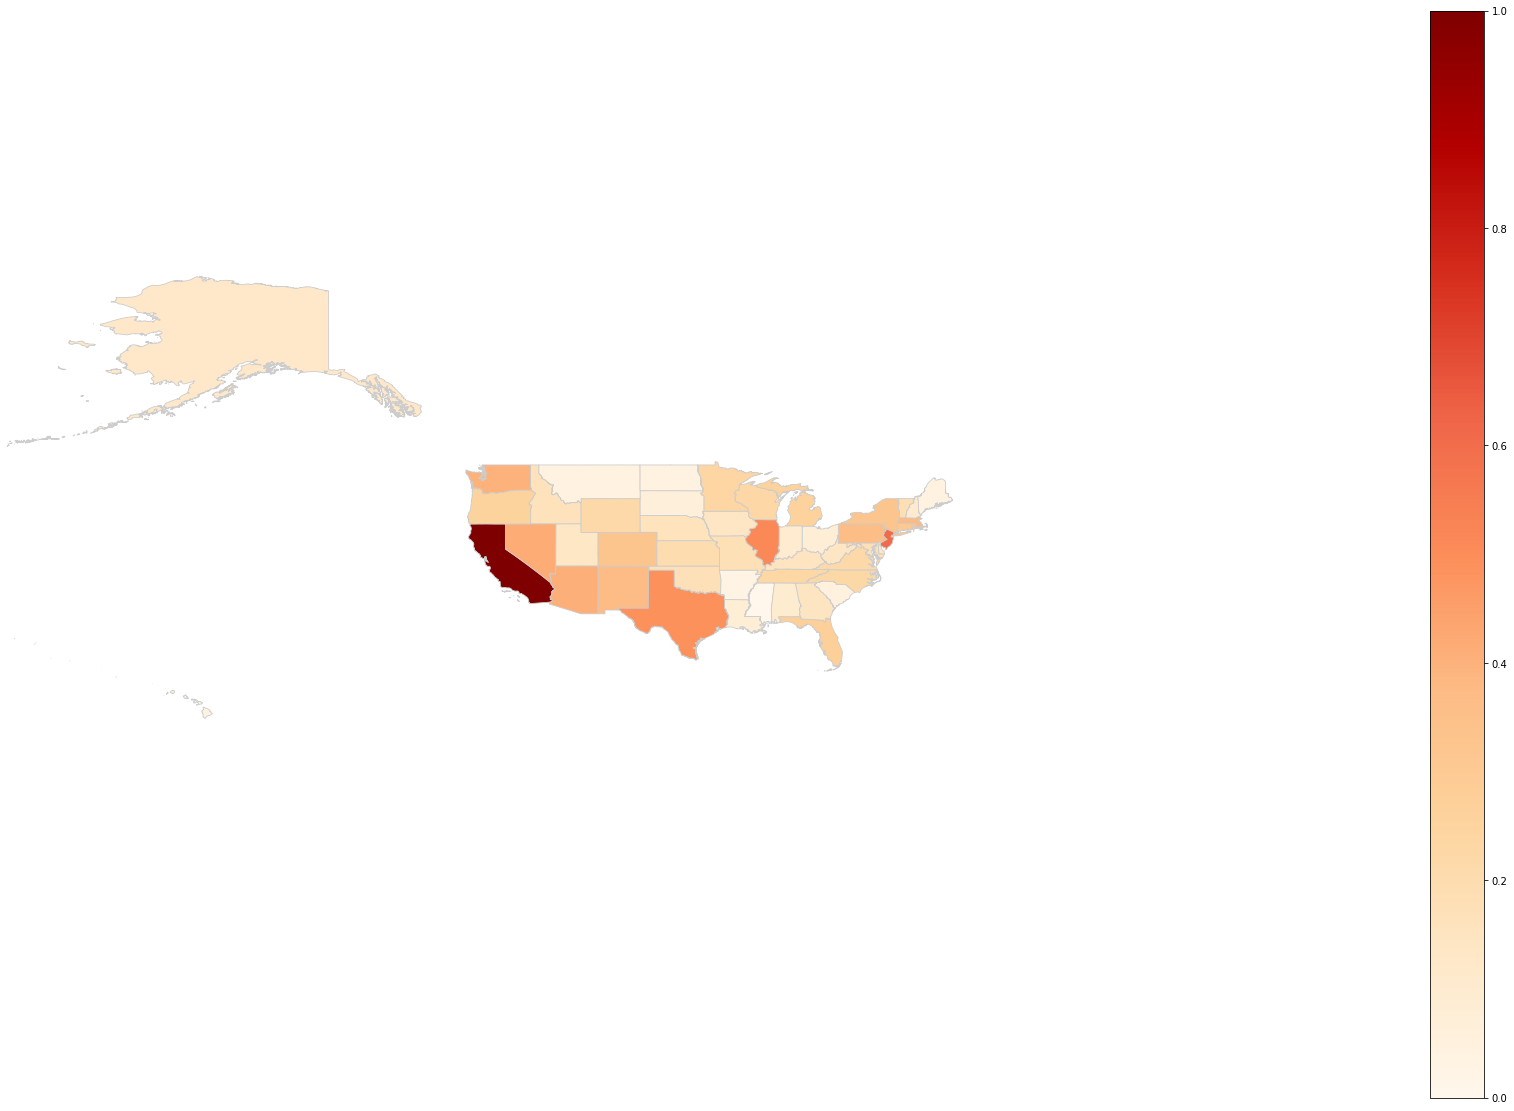

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

for i in range(lda.num_topics):
    topic_id = i  # Replace with your specific topic ID
    state_intensity = {state: distribution[topic_id] for state, distribution in state_topic_distributions.items()}

    # Load the shapefile using Geopandas
    shapefile_path = "/Users/hanmingyang/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
    gdf = gpd.read_file(shapefile_path)

    # Ensure that the GeoDataFrame has a column with state abbreviations that match your distribution keys
    gdf['state_abbr'] = gdf['STUSPS']  # Replace 'STUSPS' with the actual column name for state abbreviations if different

    # Convert the dictionary to a DataFrame
    intensity_df = pd.DataFrame(list([(i[0], i[1][1]) for i in state_intensity.items()]), columns=['index', 'intensity'])

    # Merge the DataFrame with the GeoDataFrame
    gdf = gdf.merge(intensity_df, how='left', left_on='state_abbr', right_on='index')

    # Set the size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))

    # Plot the GeoDataFrame with intensity coloring
    gdf.plot(column='intensity', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

    # Remove the axis
    ax.axis('off')

    # Set the aspect of the plot to equal and adjust the limits if needed
    ax.set_aspect('equal')
    ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2] - 200])  # set x limits to the bounds of the shapes
    ax.set_ylim([gdf.total_bounds[1] + 20, gdf.total_bounds[3]])  # set y limits to the bounds of the shapes

    # Add a colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap='OrRd'), ax=ax)

    # Show the plot
    plt.show()


In [ ]:
file_path = 'combined_data.csv'
combined_df = pd.read_csv(file_path)
# columns_to_select = ['state', 'bg', 'pi', 'pl', 'White alone', 'Black or African American alone']
# combined_df = combined_df[columns_to_select]
# print(combined_df)
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column